This notebook is made available under the GNU General Public License v3.0. (c) Francesco Mario Antonio Mitrotta 2022.

# Equilibrium Diagram of a Thin Plate under Uniaxial Compression

***

In this notebook we investigate the equilibrium diagram of a thin plate under uniaxial compression using MSC Nastran SOL 106. After our analyses on the [buckling load](01_Buckling_Analysis_of_Euler_Column.ipynb) and on the [supercritical pitchfork bifurcation](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) of Euler's column, tackling this problem we aim at building confidence in SOL 106's nonlinear capabilities using shell elements instead of beam elements.

We first define the problem and calculate the buckling load of the plate analitically. Then we set up the numerical model and perform a linear buckling analysis with SOL 105. Successively, we use SOL 106 to investigate the equilibrium diagram of our structure.

* [Problem definition and analytical buckling load](#problem-definition)
* [Setup of the numerical model](#numerical-model)
* [SOL 105 - linear buckling analysis](#linear-buckling)
* [SOL 106 - equilibrium diagram analysis](#equilibrium-diagram)
* [Conclusions](#conclusions)

## Problem definition and analytical buckling load <a name="problem-definition"></a>

***

Let's consider a flat plate of length $a$, width $b$ and thickness $t$ with simple support for all edges. As shown in the figure below, we apply a uniaxial compression $N_x$, where $N_x$ corresponds to the applied force per unit length.

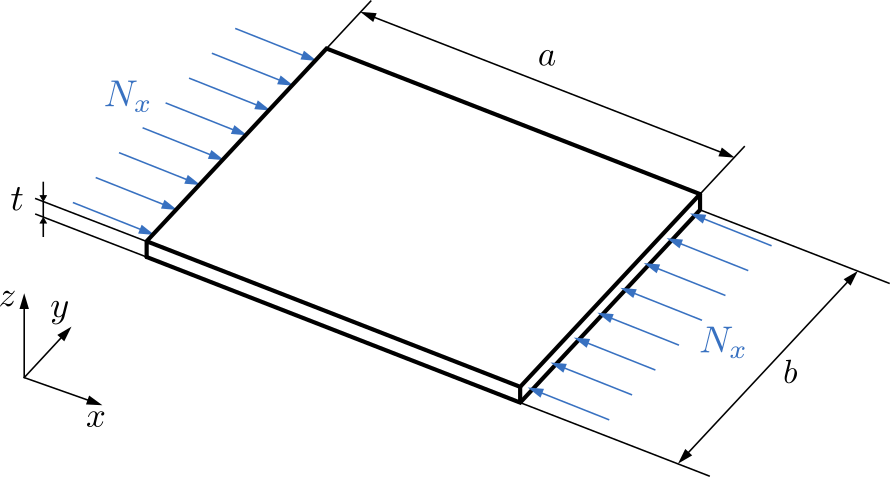

In [1]:
from IPython.display import Image  # class to display images
import os  # module with miscellaneous operating system interfaces

Image(filename=os.path.join('resources', '03_PlateGeometry.png'))

The critical buckling load $N_x^{cr}$ is given by:
$$N_x^{cr}=k\frac{\pi^2D}{b^2},$$
where the buckling coefficient $k$ is equal to:
$$k=\min\left(\frac{mb}{a}+\frac{a}{mb}\right)^2.$$
The term $m$ is the number of waves present in the buckled state along the length $a$ of the plate. $D$ is the isotropic equivalent of the bending stiffness and is obtained as:
$$D=\frac{Et^3}{12(1-\nu^2)},$$
where $E$ is the Young's modulus and $\nu$ is the Poisson's ratio. Let's have a look at how the buckling coefficient $k$ varies with the aspect ratio $a/b$ and the number of waves $m$.

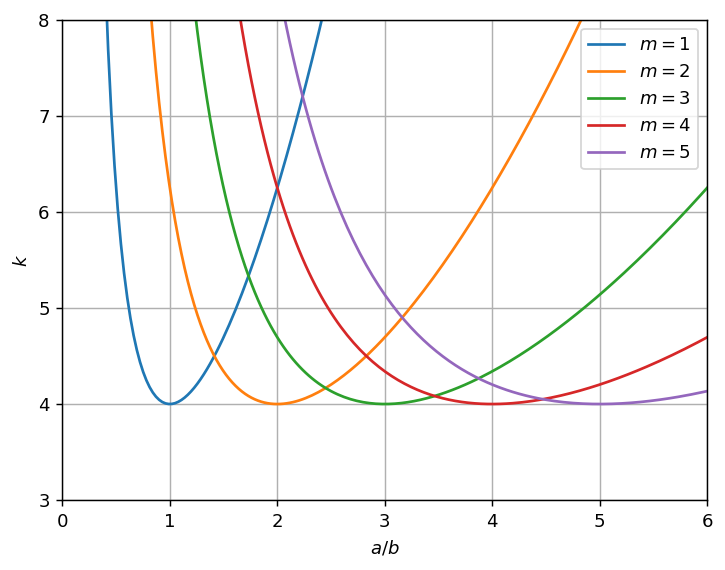

In [2]:
import matplotlib.pyplot as plt  # plotting package
import numpy as np  # package for matrix operations

plt.rcParams['figure.dpi'] = 130 # set default dpi of figures

# Plot buckling coefficient vs aspect ratio for different numbers of waves
_, ax = plt.subplots()  # create figure with one subplot
aspect_ratio = np.linspace(.1, 6, 200)  # aspect ratio interval
no_waves = np.arange(1, 6)  # numbers of waves investigated
for m in no_waves:  # iterate throught the different number of waves
    ax.plot(aspect_ratio, (m/aspect_ratio + aspect_ratio/m)**2, label=f'$m={m:d}$')  # plot buckling coefficient vs aspect ratio

# Set plot appearance
plt.xlabel('$a/b$')
plt.ylabel('$k$')
ax.set_xlim([0, 6])
ax.set_ylim([3, 8])
plt.legend()
plt.grid()
plt.show()

$k$ is minimum for integer values of the plate's aspect ratio $a/b$, where $k=4$. We choose to analyze a square plate with $a=b=250$ mm and thickness $t=6$ mm. Furthermore, we choose a material with Young's modulus $E=3105$ MPa and Poisson's ratio $\nu=0.3$. With this data, we can calculate the analytical buckling load of the plate.

In [3]:
a = b = 250. # sides of the plate [mm]
E = 3105. # Young's modulus [MPa]
nu = 0.3  # Possion's ratio
t = 6. # plate's thickness [mm]
k = 4  # buckling coefficient
D = E*t**3/(12*(1-nu**2))  # isotropic equivalent of bending stiffness
Ncr = k*np.pi**2*D/b**2  # [N/mm]
print(f'Analytical buckling load: {Ncr*1e3:.2f} N/m')

Analytical buckling load: 38794.70 N/m


The geometrical and material properties used here are inspired by the [Shallow Cylindrical Shell Snap-through example](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/mdug_SOL400/mdug_SOL400_38/mdug.SOL400.38.xhtml#TOC_Shallow_Cylindrical) from the MSC Nastran *Demontration Problems Guide - Implicit Nonlinear*.

## Setup of the numerical model <a name="numerical-model"></a>

***

Now we create a numerical model of the plate using the `pyNastran` package. The numerical approach is inspired by [this example](https://www.scc.kit.edu/scc/sw/msc/Nas101/lesson_07.pdf) on the elastic stability of a plate. We are going to apply a series of concentrated forces along one of the two loaded edges, while the other edge will be constrained so that the reaction forces act as the other part of the compression load.

We start by instantiating an object of the `BDF` class. This object is going to represent our base input file for Nastran. We will complete our input object dependeing on the analysis that we want to perform.

In [4]:
from pyNastran.bdf.bdf import BDF
base_bdf_input = BDF(debug=None)  # instantiate BDF object with the option of not displaying any debug message

We add an isotropic material to our base model with a MAT1 card. The field corresponding to the shear modulus $G$ is left blank. This will be calculated as follows:
$$E=2(1+\nu)G.$$

In [5]:
material_id = 1
base_bdf_input.add_mat1(mid=material_id, E=E, G='', nu=nu)

MAT1           1   3105.              .3

Now we define the properties of our elements adding a PHSELL card. We specify the thickness of the shell elements and their membrane, bending and transverse shear stiffness using the id of the MAT1 card.

In [6]:
property_id = 1
base_bdf_input.add_pshell(pid=property_id, mid1=material_id, t=t, mid2=material_id, mid3=material_id)

PSHELL         1       1      6.       1               1

It's time to define the nodes of our FE model. We are going to discretize our plate into square shell elements with linear length of 5 mm. In this way we'll have an odd number of nodes, which will result in a better approximation of the buckling shape. We calculate the coordinates of the nodes based on this discretization and we add the corresponding GRID cards.

In [7]:
shell_length = 5  # prescribed length of the shell elements [mm]

# Number of elements along the x- and the y-axis
no_elements_x = round(a/shell_length)
no_elements_y = round(b/shell_length)

# Coordinates of the nodes along the x- and the y-axis
x_coordinates = np.linspace(0, a, no_elements_x + 1)
y_coordinates = np.linspace(0, b, no_elements_y + 1)

# Iterate through the number of nodes along the x- and y-axis
grid_ids = np.empty((no_elements_x+1, no_elements_y+1), dtype=int)  # initialize array of node ids
for i in range(no_elements_x+1):  # iterate through elements in x-direction
    for j in range(no_elements_y+1):  # itereate through elements in y-direction
        base_bdf_input.add_grid(nid=i*(no_elements_y+1)+j+1, xyz=[x_coordinates[i], y_coordinates[j], 0.])  # add GRID card with corresponding coordinates
        grid_ids[i,j]=i*(no_elements_y+1)+j+1  # add node id to the array

Once the GRID cards have been added to the model, we can move on to the definition of the shell elements by means of CQUAD4 cards.

In [8]:
for i in range(no_elements_x):  # iterate through elements in x-direction
    for j in range(no_elements_y):  # iterate through elements in y-direction
        base_bdf_input.add_cquad4(eid=i*no_elements_y+j+1, pid=property_id, nids=[grid_ids[i,j], grid_ids[i+1,j], grid_ids[i+1,j+1],grid_ids[i,j+1]])  # add CQUAD4 card

Now we constrain the four edges using SPC1 cards and a SPCADD card to combine the constraints. Since we are going to load the right edge, we constrain it in the $y$ and $z$ directions, while the left edge is also constrained in the $x$ direction. The unloaded edges are constrained only in the $z$ direction.

In [9]:
# Constraint on left edge
left_edge_support_set_id = 1
left_edge_node_ids = list(grid_ids[0,:])
base_bdf_input.add_spc1(conid=left_edge_support_set_id, components='123', nodes=left_edge_node_ids)

# Constraint on right edge
right_edge_support_set_id = left_edge_support_set_id+1
right_edge_node_ids = list(grid_ids[-1,:])
base_bdf_input.add_spc1(conid=right_edge_support_set_id, components='23', nodes=right_edge_node_ids)

# Constraint on unloaded edges
unloaded_edges_support_set_id = right_edge_support_set_id+1
unloaded_edges_node_ids = list(grid_ids[1:-1,0]) + list(grid_ids[1:-1,-1])
base_bdf_input.add_spc1(conid=unloaded_edges_support_set_id, components='3', nodes=unloaded_edges_node_ids)

# Define SPCADD card to combine constraints
spcadd_set_id = unloaded_edges_support_set_id + 1
base_bdf_input.add_spcadd(spcadd_set_id, [left_edge_support_set_id, right_edge_support_set_id, unloaded_edges_support_set_id])

SPCADD         4       1       2       3

Finally, we select the SPCADD card in the case control deck for the single-point constraint to be applied.

In [10]:
base_bdf_input.create_subcases(0)  # initialize case control deck
base_bdf_input.case_control_deck.subcases[0].add_integer_type('SPC', spcadd_set_id)

subcase=0 already exists...skipping


Now it's time to define the applied loads. In our investigation of the equilibrium diagram we will use two different loads. One is the already mentioned compression load applied on two edges of the plate. The other is an out-of-plane load applied at the center of the plate, as shown in the figure below.

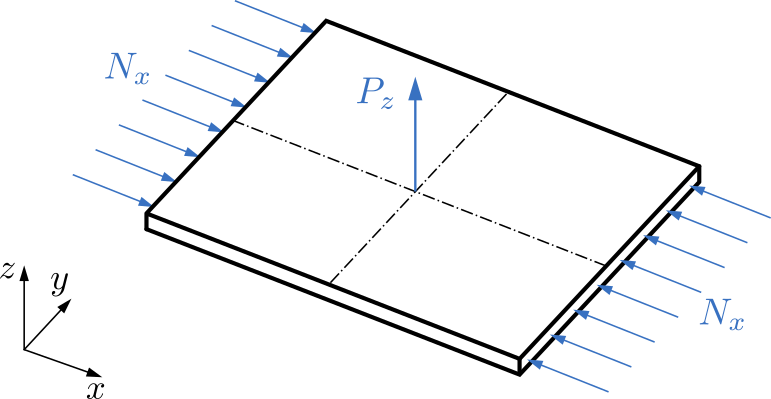

In [11]:
Image(filename=os.path.join('resources', '03_PlateLoads.png'))

We first define the compression load. As mentioned previously, we are going to explicitly define the load only over one edge of the plate, as the reaction force at the opposite edge will act as the other part of the compression. We define a series of concentrated forces on the nodes of the right edge. The sum of this forces amount to 1 N and it is equally distributed over all nodes, except for the two nodes at the corners, that take half of the force magnitude applied on the other nodes.

In [12]:
# Define force id, magnitude and direction
compression_force_set_id = spcadd_set_id+1
force_magnitude = 1/no_elements_y
force_direction = [-1., 0., 0.]

# Apply force to all points except the ones at the corners
for i in range(1, no_elements_y):
    base_bdf_input.add_force(sid=compression_force_set_id, node=grid_ids[-1,i], mag=force_magnitude, xyz=force_direction)

# Apply force to the corner points
base_bdf_input.add_force(sid=compression_force_set_id, node=grid_ids[-1,0], mag=force_magnitude/2, xyz=force_direction)
base_bdf_input.add_force(sid=compression_force_set_id, node=grid_ids[-1,-1], mag=force_magnitude/2, xyz=force_direction)

FORCE          5    2601             .01     -1.      0.      0.

Now we define the transverse force, also with a magnitude of 1 N.

In [13]:
transverse_force_set_id = compression_force_set_id+1
force_magnitude = 1.
force_direction = [0., 0., 1.]
center_node_id = grid_ids[int(no_elements_x/2+1),int(no_elements_y/2+1)]  # retrieve identification number of application node of the transverse force
base_bdf_input.add_force(sid=transverse_force_set_id, node=center_node_id, mag=force_magnitude, xyz=force_direction)

FORCE          6    1353              1.      0.      0.      1.

Finally, we define some parameters for the processing of the output data.

In [14]:
base_bdf_input.add_param('POST', [1])  # store results in op2 file
base_bdf_input.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type')  # request neither sorted nor unsorted Bulk Data to be printed
base_bdf_input.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT'])  # store displacement data of all nodes in the op2 file
base_bdf_input.case_control_deck.subcases[0].add_result_type('SPCFORCES', 'ALL', ['PLOT'])  # store single point constraint forces data in the op2 file
base_bdf_input.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT'])  # store form and type of applied load vector

Before moving to the analyses, let's print some information about our `BDF` object.

In [15]:
print(base_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.loads[5]: 51
  FORCE:   51

bdf.loads[6]: 1
  FORCE:   1

bdf.spcadds[4]: 1
  SPCADD:  1

bdf.spcs[1]: 1
  SPC1:    1

bdf.spcs[2]: 1
  SPC1:    1

bdf.spcs[3]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 2601

bdf.elements: 0
  CQUAD4   : 2500

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




## SOL 105 - linear buckling analysis <a name="linear-buckling"></a>

***

Now we want to calculate the linear buckling load of our numerical model. For this purpose we create a copy of our base model and we select SOL 105 as solution sequence.

In [16]:
linear_buckling_input = base_bdf_input.__deepcopy__({})
linear_buckling_input.sol = 105

For the linear buckling analysis we need to define two subcases: one to apply the load in compression and the other to calculate the buckling eigenvalues. We create the first subcase selecting the compression force as external static load set. For this purpose we use the `create_static_load_subcase` function from the `pynastran_utils` module.

In [17]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

load_application_subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=linear_buckling_input, subcase_id=load_application_subcase_id, load_set_id=compression_force_set_id)

For the second subcase we need to define the parameters for the calculation of the eigenvalues. This is done by means of the EIGRL card, which is used to carry out a real eigenvalue analysis with the Lanczos method. We only ask for the calculation of the first positive root. Then we create the subcase and we select our EIGRL card to define the real eigenvalue extraction parameters.

In [18]:
# Define the eigenvalue calculation parameters with the EIGRL card
eigrl_set_id = transverse_force_set_id+1
linear_buckling_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)

# Create second subcase
eigenvalue_calculation_subcase_id = 2
linear_buckling_input.create_subcases(eigenvalue_calculation_subcase_id)
linear_buckling_input.case_control_deck.subcases[eigenvalue_calculation_subcase_id].add_integer_type('METHOD', eigrl_set_id)  # select EIGRL card as eigenvalue calculation method in the case control deck

At this point we need to define the directory where we will run the analyses of this notebook and choose a name for our input file. Then we write the bdf file and run the Nastran analysis using the function `run_analysis` from the `pynastran_utils` module.

In [19]:
analysis_directory_name = '03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_name = 'linear_buckling'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=linear_buckling_input, filename=input_name, run_flag=False)

Finally, we can read the results from the output op2 file. The buckling load is given by the multiplication of the applied load by the eigenvalue resulting from the analysis. Since the applied buckling load was 1 N, the buckling load is equal to the eigenvalue itself. For the sake of consistency with the analytical calculation, we express the buckling load in terms of N/m, so we have to divide the buckling load obtained in Nastran by the width of the plate.

In [20]:
from pyNastran.op2.op2 import read_op2  # function to read the op2 file
import matplotlib.pyplot as plt  # plotting library

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
linear_buckling_op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Find eigenvalue and print buckling load
sol_105_buckling_load = linear_buckling_op2_output.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'SOL 105 buckling load: {sol_105_buckling_load/(b*1e-3):.1f} N/m')
print(f'Difference with respect to analytical buckling load: {(sol_105_buckling_load/(b*1e-3)/(Ncr*1e3)-1)*100:.2f} %')

SOL 105 buckling load: 36262.2 N/m
Difference with respect to analytical buckling load: -6.53 %


We observe a $6.5\%$ difference with respect to the analytical calculation, most probably ascribable to the discretization error.

Finally, we plot the buckling mode calling the function `plot_buckling_mode` from the `pynastran_utils` module.

(<Figure size 832x624 with 2 Axes>,
 <Axes3DSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

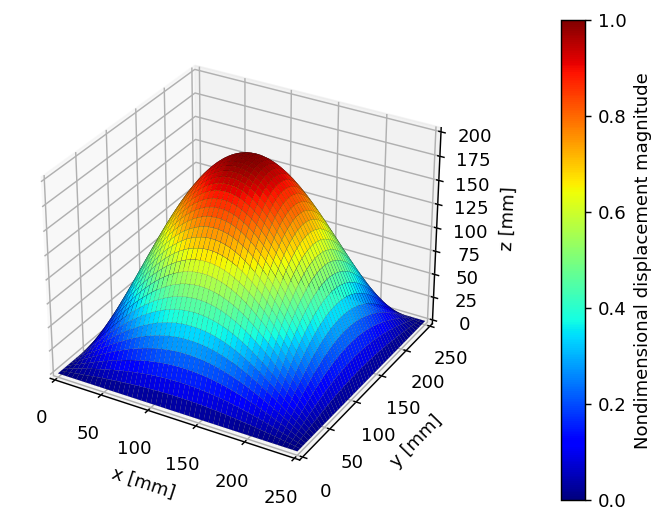

In [21]:
pynastran_utils.plot_buckling_mode(op2_object=linear_buckling_op2_output, subcase_id=eigenvalue_calculation_subcase_id)

## SOL 106 - equilibrium diagram analysis <a name="equilibrium-diagram"></a>

***

At this point we turn our attention to the study of the equilibrium diagram of the plate. This can only be obtained using nonlinear analysis. Furthermore, we need to use the arc-length method in order to investigate any unstable path of the equilibrium diagram. As a consequence for this analysis we choose SOL 106 as the solution sequence.

In [22]:
nonlinear_analysis_input = base_bdf_input.__deepcopy__({})
nonlinear_analysis_input.sol = 106

Now we need to define the nonlinear analysis parameters. We begin by specifiying the parameter `PARAM,LGDISP,1` to enable the large displacement effects for all nonlinear structural element types having large displacement capability.

In [23]:
nonlinear_analysis_input.add_param('LGDISP', [1])

PARAM     LGDISP       1

Then we define the NLPARM and the NLPCI cards, where the former sets the general parameters for the nonlinear iteration strategy and the latter sets the parameters for the arc-length method. The parameters are analogous to the ones use in our [previous notebook](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb), which are inspired from the [Shallow Cylindrical Shell Snap-through example](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/mdug_SOL400/mdug_SOL400_38/mdug.SOL400.38.xhtml#TOC_Shallow_Cylindrical) of the MSC Nastran *Demontration Problems Guide - Implicit Nonlinear*.

In [24]:
nlparm_id = 1
nonlinear_analysis_input.add_nlparm(nlparm_id=nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)
nonlinear_analysis_input.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=2000)
nonlinear_analysis_input.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)  # select NLPARM card in case control deck

Now we have to define the differet load sets that we are going to apply in the subcases of our analysis. We consider four load combinations:
* compression load only with magnitude $N_x/N_x^{cr}=1.5$;
* compression load with magnitude $N_x/N_x^{cr}=1.5$ and transverse load with magnitude $P_z/N_x^{cr}b = 1/100$;
* compression load with magnitude $N_x/N_x^{cr}=1.5$ and transverse load applied in the opposite direction with $P_z/N_x^{cr}b=-1/40$;
* no applied load.

In [25]:
# Compression only
compression_load_set_id = transverse_force_set_id + 1
nonlinear_analysis_input.add_load(sid=compression_load_set_id, scale=1., scale_factors=[sol_105_buckling_load*1.5], load_ids=[compression_force_set_id])

# Compression and transverse load
combined_load_set_id = compression_load_set_id + 1
nonlinear_analysis_input.add_load(sid=combined_load_set_id, scale=1., scale_factors=[sol_105_buckling_load*1.5, sol_105_buckling_load/100], load_ids=[compression_force_set_id, transverse_force_set_id])

# Compression and transverse load in opposite direction
combined_load_opposite_direction_set_id = combined_load_set_id+1
nonlinear_analysis_input.add_load(combined_load_opposite_direction_set_id, scale=1., scale_factors=[sol_105_buckling_load*1.5, -sol_105_buckling_load/40], load_ids=[compression_force_set_id, transverse_force_set_id])

# Zero load
zero_load_set_id = combined_load_opposite_direction_set_id+1
nonlinear_analysis_input.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[compression_force_set_id])

LOAD          10      1.      0.       5

The last step before running the analysis is the definition of the subcases. We define an analogous subcase sequence to the final investigation of the Euler's column supercritical pitchfork bifurcation carried out in our [last notebook](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb#final).

1. Apply the load set with $N_x/N_x^{cr}=1.5$ and $P_z/N_x^{cr}b=1/100$.
2. Remove the transverse load using the load set with the compression load only.
3. Apply the load set with compression load and transverse load in opposite direction.
4. Remove the transverse load using the load set with the compression load only.
5. Remove the compression load using the load set with no applied load.
6. Apply the load set with $N_x/N_x^{cr}=1.5$ and $P_z/N_x^{cr}b=-1/40$.

Similarly to Euler's column, for the last two subcases we need to use the Newton method in place of the arc-length method, as the latter fails to follow the correct direction of the equilibrium path.

In [26]:
# Create first 4 subcases analyzed with arc-length method
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_analysis_input, subcase_id=1, load_set_id=combined_load_set_id)  # create subcase 1
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_analysis_input, subcase_id=2, load_set_id=compression_load_set_id)  # create subcase 2
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_analysis_input, subcase_id=3, load_set_id=combined_load_opposite_direction_set_id)  # create subcase 3
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_analysis_input, subcase_id=4, load_set_id=compression_load_set_id)  # create subcase 4

# Create last 2 subcaes analyzed with Newton method
nlparm2_id = 2  # identification card of NLPARM card defining the Newton method
nonlinear_analysis_input.add_nlparm(nlparm2_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)  # add NLPARM card defining the Newton method
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_analysis_input, subcase_id=5, load_set_id=zero_load_set_id)  # create subcase 5
nonlinear_analysis_input.case_control_deck.subcases[5].add_integer_type('NLPARM', nlparm2_id)  # select NLPARM card associated to Newton method for subcase 5
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_analysis_input, subcase_id=6, load_set_id=combined_load_opposite_direction_set_id)  # create subcase 6
nonlinear_analysis_input.case_control_deck.subcases[6].add_integer_type('NLPARM', nlparm2_id)  # select NLPARM card associated to Newton method for subcase 6

Let's run the analysis.

In [27]:
input_name = 'equilibrium_paths_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=nonlinear_analysis_input, filename=input_name, run_flag=False)

Nastran job equilibrium_paths_nonlinear_analysis.bdf completed
Wall time: 225.0 s


Once the analysis is completed, we can read the results in the op2 file and plot the equilibrium diagram. Similarly to our study on Euler's column, we want to visualize the equilibrium paths described by the nonlinear analysis in the different subcases. For this reason, we define the functions `plot_2d_equilibrium_paths` and `plot_3d_equilibrium_paths`. We visualize the equilibrium diagram in terms of the displacement $u_z$ at the center of the plate. In the 2D plots we plot the displacement versus the load step, the applied load along the $x$-axis and the applied load along the $z$-axis, while in the 3D plot we look at the change of $u_z$ for the different combinations of loads along the $x$- and $z$-axis. The loads are always nondimensionalized with respect to the critical buckling load $N_x^{cr}$ obtained with the previous numerical analysis.

In [28]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

markers = list(Line2D.markers.keys())[2:]  # store list of marker characters to plot different marker for each subcase

def plot_2d_equilibrium_paths(disp, steps, loads):
    # Create figure with subplots
    _, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
    # Iterate over the subcases
    for subcase_id in disp:
        # Take displacement along z
        u_z = disp[subcase_id][:,2]
        # Print displacement along z at the end of subcase
        print(f'Subcase {subcase_id:d}: u_z = {u_z[-1]:.2f} mm')
        # Plot load step vs displacement along z
        axs[0].plot(steps[subcase_id], u_z, markers[subcase_id - 1], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along x vs displacement along z
        axs[1].plot(-loads[subcase_id][:,0]/sol_105_buckling_load, u_z, markers[subcase_id - 1], label='Subcase {:d}'.format(subcase_id))  # sign of load along x is inverted to show a positive load in the plot
        # Plot applied load along y vs displacement along z
        axs[2].plot(loads[subcase_id][:,2]/sol_105_buckling_load, u_z, markers[subcase_id - 1], label='Subcase {:d}'.format(subcase_id))
    # Set plot appearance
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel('$u_z$ [mm]')
    axs[0].grid(visible=True)
    axs[1].set_xlabel('$N_x/N_x^{cr}$')
    axs[1].grid(visible=True)
    axs[2].set_xlabel('$P_z/N_x^{cr}b$')
    axs[2].grid(visible=True)
    axs[0].legend()
    # Show plot
    plt.show()

def plot_3d_equilibrium_paths(disp, loads):
    # Create figure with three-dimensional axes
    plt.figure()
    ax_3d = plt.axes(projection='3d')
    # Plot load applied along x vs displacement along z of pin-supported node vs applied along y
    for subcase_id in disp:
        ax_3d.plot3D(-loads[subcase_id][:,0]/sol_105_buckling_load, disp[subcase_id][:,2], loads[subcase_id][:,2]/sol_105_buckling_load, markers[subcase_id - 1], label='Subcase {:d}'.format(subcase_id))  # sign of load along x is inverted to show a positive load in the plot
    ax_3d.set_xlabel('$N_x/N_x^{cr}$')
    ax_3d.set_ylabel('$u_z$ [mm]')
    ax_3d.set_zlabel('$P_z/N_x^{cr}b$')
    ax_3d.legend()
    ax_3d.grid(visible=True)
    plt.show()

Let's read the op2 file and find the history of load steps, applied loads and displacements at the center of the plate using the function `read_load_displacement_history_from_op2`. Then let's produce the plots of the equilibrium diagram.

Subcase 1: u_z = 9.55 mm
Subcase 2: u_z = 8.66 mm
Subcase 3: u_z = -10.62 mm
Subcase 4: u_z = -8.66 mm
Subcase 5: u_z = -0.00 mm
Subcase 6: u_z = -10.62 mm


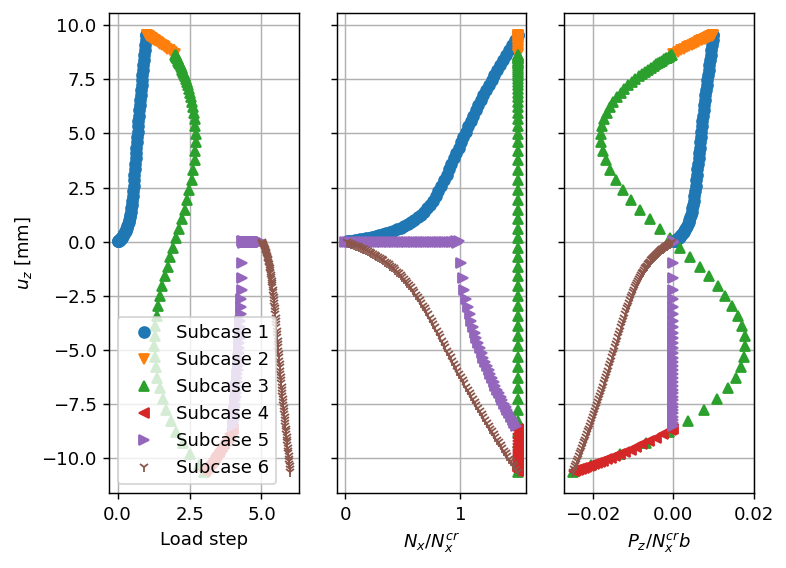

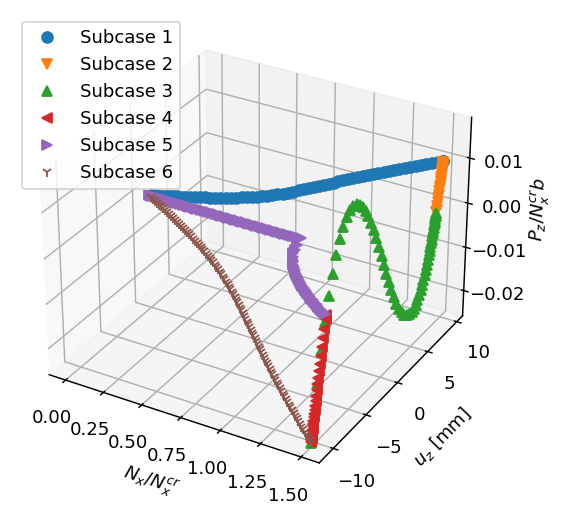

In [29]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)

# Read load-displacement history
load_steps, applied_loads, center_node_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=center_node_id)

# Plot 2D and 3D equilibrium paths
plot_2d_equilibrium_paths(center_node_displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(center_node_displacements, applied_loads)

From the results it is possible to recognize a supercritical pitchfork bifurcation at the buckling load. This is analogous to what happens for Euler's column. In fact the current problem is very similar and can be thought as an Euler's column with the addition of a width dimension to the structure. We can make the following observations about the different subcases.
1. In subcase 1 we move along the path of the broken pitchfork corresponding to the plate deflected upwards.
2. In subcase 2 we move from the broken pitchfork to the unbroken pitchfork by removing the transverse force.
3. In subcase 3 we observe a path of the equilibrium diagram describing a snap-through behavior of the plate.
4. In subcase 4 we end on a point of the supercritical pitchfork on the side corresponding to the plate deflected downwards. We can notice how the vertical displacement is equal and opposite with respect ot the displacement at the end of subcase 2.
5. In subcase 5 we visualize the downward deflection side of the pitchfork until the plate gets back to the non-buckled configuration and finally to its undeformed state.
6. In subcase 6 we visualize the broken pitchfork on the downward deflection side. At the end of the subcase we find the same value of displacement as obtained at the end of subcase 3. The broken pitchfork obtained in subcase 6 is not symmetric with respect to the broken pitchfork obtained in subcase 1 because a different transverse force is applied.

## Conclusions <a name="conclusions"></a>

***

We have tested SOL 106's nonlinear analysis capabilities on the structural model of a thin plate employing shell elements. Using the arc-length method we have successfully explored the different paths of the equilibrium diagram of our structure and have correctly observed a supercritical pitchfork bifurcation at the buckling load predicted by SOL 105.

The results obtained here give us confidence to move towards more complicated structures. In our [next notebook](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb) we will apply SOL 106's nonlinear buckling method to a box beam structure modelled with shell elements.